In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.validation import _check_large_sparse
from sklearn.metrics import pairwise_distances_argmin_min, jaccard_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import ClassifierChain
from sklearn import svm
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [2]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x else 0)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [3]:
X_df = pd.read_csv('../new_data/Persian/persian_dataset.csv', index_col=None)
Y_df = pd.read_csv('../new_data/Persian/labels.csv', usecols=['filename', 'emotions'], index_col='filename')
Y_df["emotions"] = Y_df["emotions"].apply(eval)
unique_items = to_1D(Y_df["emotions"]).unique()
labels_expanded = boolean_df(Y_df['emotions'], unique_items)
labels_expanded

,annoyed,contempt,anger,none,hatred,disgust,furious
filename,,,,,,,
persian/vid_1.mp4,1,0,0,0,0,0,0
persian/vid_10.mp4,0,1,0,0,0,0,0
persian/vid_11.mp4,0,1,0,0,0,0,0
persian/vid_12.mp4,0,1,0,0,0,0,0
persian/vid_13.mp4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
persian/vid_93.mp4,0,0,0,0,1,0,0
persian/vid_94.mp4,0,0,0,1,0,0,0
persian/vid_95.mp4,0,1,0,0,1,0,0


In [4]:
X_df['none']  = np.NaN
X_df['furious']  = np.NaN
X_df['anger']  = np.NaN
X_df['annoyed']  = np.NaN
X_df['contempt']  = np.NaN
X_df['disgust']  = np.NaN
X_df['hatred']  = np.NaN


In [ ]:
X_df.head()

In [5]:
for index, row in X_df.iterrows():
    # print(index, row)
    filename = X_df.iloc[index]['filename']
    # print(labels_expanded.loc[filename]['none':'hatred'].to_list())
    X_df.at[index,'none'] = labels_expanded.at[filename,'none']
    X_df.at[index,'furious'] = labels_expanded.at[filename,'furious']
    X_df.at[index,'anger'] = labels_expanded.at[filename,'anger']
    X_df.at[index,'annoyed'] = labels_expanded.at[filename,'annoyed']
    X_df.at[index,'contempt'] = labels_expanded.at[filename,'contempt']
    X_df.at[index,'disgust'] = labels_expanded.at[filename,'disgust']
    X_df.at[index,'hatred'] = labels_expanded.at[filename,'hatred']

## Ablation Studies
Run the cell below to remove columns for ablation studies and then run the training cell.

In [ ]:
## Ablation cols
# ablation_cols = ['AU01_r','AU02_r','AU04_r','AU05_r','AU06_r','AU07_r','AU09_r', 'AU10_r','AU12_r','AU14_r','AU15_r','AU17_r','AU20_r','AU23_r','AU25_r','AU26_r','AU45_r']
ablation_cols = ['pose_Rx','pose_Ry','pose_Rz','gaze_angle_x','gaze_angle_y']

In [ ]:
X_df = X_df.drop(columns=ablation_cols)
X_df

### Min-Max Scaling
To limit the scale of features

In [6]:
cols_to_scale = list (
    set(X_df.columns.to_list()) - set(['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success', 'none', 'furious', 'anger', 'annoyed', 'contempt', 'disgust', 'hatred'])
)
scaler = MinMaxScaler()
X_df[cols_to_scale] = scaler.fit_transform(X_df[cols_to_scale])

In [ ]:
X_df.tail()

## Splitting into train and test
Randomly select 25% of videos apart for testing.

In [14]:
videos = X_df['filename'].unique()
test_videos = pd.Series(videos).sample(frac=0.25)
print(test_videos.to_list())

['persian/vid_59.mp4', 'persian/vid_79.mp4', 'persian/vid_40.mp4', 'persian/vid_10.mp4', 'persian/vid_1.mp4', 'persian/vid_5.mp4', 'persian/vid_44.mp4', 'persian/vid_85.mp4', 'persian/vid_25.mp4', 'persian/vid_75.mp4', 'persian/vid_66.mp4', 'persian/vid_50.mp4', 'persian/vid_81.mp4', 'persian/vid_60.mp4', 'persian/vid_87.mp4', 'persian/vid_90.mp4', 'persian/vid_35.mp4', 'persian/vid_37.mp4', 'persian/vid_42.mp4', 'persian/vid_69.mp4', 'persian/vid_70.mp4', 'persian/vid_52.mp4', 'persian/vid_53.mp4', 'persian/vid_82.mp4']


In [15]:
metadata_cols = ['frame', 'face_id', 'culture', 'filename', 'timestamp']
label_cols = ['none', 'furious', 'anger', 'annoyed', 'contempt', 'disgust', 'hatred']

print(X_df.head())

# test_videos = ['persian/vid_40.mp4', 'persian/vid_66.mp4', 'persian/vid_18.mp4', 'persian/vid_96.mp4', 'persian/vid_65.mp4', 'persian/vid_51.mp4', 'persian/vid_85.mp4', 'persian/vid_87.mp4', 'persian/vid_27.mp4','persian/vid_21.mp4', 'persian/vid_4.mp4', 'persian/vid_61.mp4', 'persian/vid_12.mp4', 'persian/vid_81.mp4','persian/vid_56.mp4', 'persian/vid_55.mp4',  'persian/vid_38.mp4', 'persian/vid_8.mp4',  'persian/vid_91.mp4', 'persian/vid_22.mp4', 'persian/vid_36.mp4', 'persian/vid_7.mp4']
# test_videos = ['na/vid_6.mp4', 'na/vid_19.mp4', 'na/vid_43.mp4', 'na/vid_25.mp4', 'na/vid_23.mp4', 'na/vid_10_1.mp4', 'na/vid_72.mp4', 'na/vid_34.mp4', 'na/vid_90.mp4', 'na/vid_92.mp4', 'na/vid_39.mp4', 'na/vid_30.mp4', 'na/vid_3.mp4', 'na/vid_33.mp4', 'na/vid_4.mp4', 'na/vid_31.mp4', 'na/vid_53.mp4', 'na/vid_52.mp4', 'na/vid_55.mp4', 'na/vid_59.mp4', 'na/vid_22.mp4', 'na/vid_11.mp4', 'na/vid_79.mp4', 'na/vid_54.mp4', 'na/vid_87.mp4', 'na/vid_63.mp4', 'na/vid_12.mp4', 'na/vid_10_2.mp4', 'na/vid_97.mp4', 'na/vid_70.mp4', 'na/vid_42.mp4', 'na/vid_49.mp4', 'na/vid_77.mp4']
train_videos = np.array(list(set(videos) - set(test_videos)))
test_df = X_df[X_df['filename'].isin(test_videos)]
metadata_test = test_df[metadata_cols]
metadata_test.reset_index(inplace=True)
y_test = test_df[label_cols].values
X_test = test_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'] + label_cols).values

            filename  culture  frame  face_id  timestamp  confidence  success  \
0  persian/vid_1.mp4  persian      1        0      0.000        0.98        1   
1  persian/vid_1.mp4  persian      2        0      0.033        0.98        1   
2  persian/vid_1.mp4  persian      3        0      0.067        0.98        1   
3  persian/vid_1.mp4  persian      4        0      0.100        0.98        1   
4  persian/vid_1.mp4  persian      5        0      0.133        0.98        1   

     AU01_r    AU02_r    AU04_r  ...   pose_Rz  gaze_angle_x  gaze_angle_y  \
0  0.246073  0.056206  0.096197  ...  0.493286      0.636448      0.600127   
1  0.044503  0.000000  0.000000  ...  0.491746      0.668991      0.615336   
2  0.026178  0.000000  0.000000  ...  0.491966      0.676430      0.603295   
3  0.000000  0.000000  0.000000  ...  0.491966      0.697815      0.600127   
4  0.000000  0.000000  0.000000  ...  0.491305      0.716876      0.600760   

   none  furious  anger  annoyed  contempt  

In [ ]:
len(X_test)


In [ ]:
y_test[800:805,:]


In [ ]:
metadata_test.iloc[800:805]

## Training with Cross-validation

### Classifier Chain
Choose one of the classifiers for CC: base_knn, base_rf, base_xgb

In [37]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier


kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []
# metadata_test.reset_index(inplace=True)

col_indices = {i:label for (i,label) in enumerate(label_cols)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    # print(videos[train])
    # print(videos[test])
    print('%d-th split: train: %d, test: %d' % (i+1, len(train_videos[train]), len(train_videos[test])))
    train_df = X_df[X_df['filename'].isin(train_videos[train])]
    print(train_videos[train])
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y_train = train_df[label_cols].values
    X_train = train_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'] + label_cols).values
    valid_df = X_df[X_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[label_cols].values
    X_valid = valid_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'] + label_cols).values
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    base_knn =  KNeighborsClassifier(n_neighbors=5,)
    base_xgb = XGBClassifier(objective="binary:logistic", learning_rate=0.2, eval_metric='logloss')
    base_rf = RandomForestClassifier()

    # ovr = MultiOutputClassifier(base_xgb)
    # ovr.fit(X_train, y_train)
    # valid_pred_ovr = ovr.predict(X_valid)
    # ovr_jaccard_score = jaccard_score(y_valid, valid_pred_ovr, average='samples')
    # ovr_ham_loss = metrics.hamming_loss(y_valid, valid_pred_ovr)
    # print("One-vs-Rest validation Jaccard score:" , ovr_jaccard_score)
    # print("One-vs-Rest validation Hamming loss: " , ovr_ham_loss)

   
    # Y_pred_ovr = ovr.predict(X_test)
    # a = jaccard_score(y_test, Y_pred_ovr, average='samples')
    # b = metrics.hamming_loss(y_test, Y_pred_ovr)
    # # print(Y_pred_ovr[800:805,:])
    # # print(y_test[800:805,:])

    # print("One-vs-Rest test Jaccard score: ", a)
    # print("One-vs-Rest test Hamming loss: " , b)
    
    
    chains = [ClassifierChain(base_knn, order='random', random_state=0) for i in range(7)]
    best_model_index = 0
    best_jac = 0            
    for j, model in enumerate(chains):
        model.fit(X_train, y_train)
        valid_pred = model.predict(X_valid)
        val_score =jaccard_score(y_valid, valid_pred, average='samples')
        if val_score > best_jac:
            best_model_index = j
            best_jac = val_score
            
        
    # predict on validation data
    valid_pred_chains = chains[best_model_index].predict(X_valid)
    chain_jaccard_scores = jaccard_score(y_valid, valid_pred_chains >= .5,
                                    average='samples')

    
    print("CC Validation Jaccard Score:\n ", chain_jaccard_scores)

    chain_hamming_loss =metrics.hamming_loss(y_valid, valid_pred_chains >= .5)
                
    print("CC Validation Hamming Loss:\n ", chain_hamming_loss)

    # test on test data
    Y_pred_chains = chains[best_model_index].predict(X_test)
    chain_jaccard_scores = jaccard_score(y_test, Y_pred_chains >= .5,
                                    average='samples')
                    

    # chain01_scores = [metrics.zero_one_loss(y_test, Y_pred_chain) for Y_pred_chain in Y_pred_chains]

    frames_mean_jac_test.append(np.mean(chain_jaccard_scores))
    print("CC Test Jaccard Score: \n ", chain_jaccard_scores)

    chain_hamming_loss = metrics.hamming_loss(y_test, Y_pred_chains) 
                
    frames_mean_hm_test.append(np.mean(chain_hamming_loss))
    print("CC Test Hamming Loss:\n ", chain_hamming_loss)
    ## voting predicted labels
    # test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    # test_result_df.update(metadata_test)
    temp_df = pd.DataFrame(data=Y_pred_chains, columns=label_cols)
    test_result_df = pd.concat([metadata_test, temp_df], axis=1)
    video_groups = test_result_df.groupby('filename')[label_cols].sum()
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(test_df[test_df['filename'] == v].iloc[0][label_cols])
        
        num_1s = test_df[test_df['filename'] == v].iloc[0][label_cols].sum()
        num_1s = int(num_1s)
        # ##### TODO: Bug is somewhere here:
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0
        # print("          &&&&&&&&&&&&&&&&            ")
    print(np.array(ground_truth_video_labels,  dtype=int).shape)
    print(video_groups.values.shape)

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)


1-th split: train: 56, test: 15
['persian/vid_4.mp4' 'persian/vid_97.mp4' 'persian/vid_29.mp4'
 'persian/vid_36.mp4' 'persian/vid_20.mp4' 'persian/vid_95.mp4'
 'persian/vid_62.mp4' 'persian/vid_58.mp4' 'persian/vid_84.mp4'
 'persian/vid_89.mp4' 'persian/vid_46.mp4' 'persian/vid_11.mp4'
 'persian/vid_68.mp4' 'persian/vid_51.mp4' 'persian/vid_80.mp4'
 'persian/vid_67.mp4' 'persian/vid_26.mp4' 'persian/vid_30.mp4'
 'persian/vid_31.mp4' 'persian/vid_72.mp4' 'persian/vid_57.mp4'
 'persian/vid_63.mp4' 'persian/vid_93.mp4' 'persian/vid_74.mp4'
 'persian/vid_76.mp4' 'persian/vid_15.mp4' 'persian/vid_43.mp4'
 'persian/vid_6.mp4' 'persian/vid_3.mp4' 'persian/vid_21.mp4'
 'persian/vid_32.mp4' 'persian/vid_19.mp4' 'persian/vid_64.mp4'
 'persian/vid_24.mp4' 'persian/vid_38.mp4' 'persian/vid_2.mp4'
 'persian/vid_91.mp4' 'persian/vid_54.mp4' 'persian/vid_94.mp4'
 'persian/vid_41.mp4' 'persian/vid_71.mp4' 'persian/vid_28.mp4'
 'persian/vid_96.mp4' 'persian/vid_22.mp4' 'persian/vid_92.mp4'
 'persian/vi

## Classification Report

In [38]:
print('------------------- Frame-level F1 -----------------')
print(metrics.classification_report(y_test, Y_pred_chains, target_names=label_cols))
print('------------------- Video-level F1 -----------------')
print(metrics.classification_report(np.array(ground_truth_video_labels,  dtype=int),  video_groups.values, target_names=label_cols))

------------------- Frame-level F1 -----------------
              precision    recall  f1-score   support

        none       0.02      0.06      0.02        93
     furious       0.71      0.06      0.11      1265
       anger       0.58      0.26      0.36      1447
     annoyed       0.38      0.43      0.40       781
    contempt       0.07      0.25      0.11       180
     disgust       0.00      0.00      0.00        81
      hatred       0.41      0.23      0.29       871

   micro avg       0.28      0.22      0.25      4718
   macro avg       0.31      0.19      0.19      4718
weighted avg       0.51      0.22      0.27      4718
 samples avg       0.29      0.23      0.24      4718

------------------- Video-level F1 -----------------
              precision    recall  f1-score   support

        none       0.00      0.00      0.00         2
     furious       0.00      0.00      0.00         9
       anger       0.71      0.50      0.59        10
     annoyed       0.43   

Print average of metrics


In [39]:
print("F-jac: ", np.mean(frames_mean_jac_test))
print("V-jac: ", np.mean(videos_mean_jac_test))
print("F-ham: ", np.mean(frames_mean_hm_test))
print("V-ham: ", np.mean(videos_mean_hm_test))

F-jac:  0.1935324614115706
V-jac:  0.26305555555555554
F-ham:  0.31560874614957324
V-ham:  0.2690476190476191


In [40]:
videos_mean_jac_test

[0.17361111111111108,
 0.2708333333333333,
 0.375,
 0.23888888888888885,
 0.2569444444444444]

In [ ]:
print(test_videos.to_list())

## Confused frames
The cell below finds frames that are misclassified

In [ ]:

# Confusions
confused = 0
for i,_ in enumerate(y_test):
    if np.subtract(y_test[i], test_result_df.iloc[i][label_cols].to_numpy(dtype=int)).sum() != 0.0:
        confused += 1
        print(metadata_test.iloc[i], "------- Actual: ", y_test[i], " ----- pred: ", Y_pred_chains[i])
print("confused: ", confused)

In [ ]:
print("F-jac: ", np.mean(frames_mean_jac_test))
print("V-jac: ", np.mean(videos_mean_jac_test))
print("F-ham: ", np.mean(frames_mean_hm_test))
print("V-ham: ", np.mean(videos_mean_hm_test))

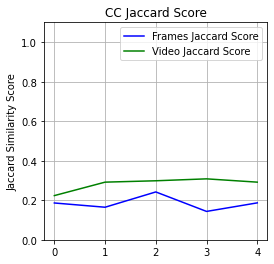

In [20]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.0, 1.1])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='best')
plt.show()

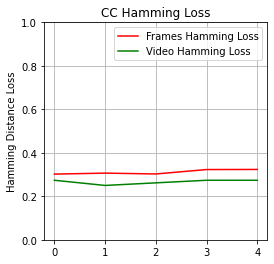

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, 1.0])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

### ML KNN

In [23]:
from skmultilearn.adapt import MLkNN, MLTSVM
import sklearn.metrics as metrics

## MLTSVM is not compatible with later versions of numpy

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []
col_indices = {i:label for (i,label) in enumerate(label_cols)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    print('%d-th split: train: %d, validation: %d' % (i+1, len(videos[train]), len(videos[test])))
    train_df = X_df[X_df['filename'].isin(train_videos[train])]
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y_train = train_df[label_cols].values
    X_train = train_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'] + label_cols).values
    valid_df = X_df[X_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[label_cols].values
    X_valid = valid_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']+ label_cols).values
    
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    classifier = MLkNN(k=5)
    # classifier = MLTSVM(c_k = 2**-1)
    prediction = classifier.fit(X_train, y_train).predict(X_valid)

    # Predicting on validation set
    print("Validation Hamming Loss:\n ", metrics.hamming_loss(y_valid, prediction))

    # Predicting on test set
    y_test_pred = classifier.predict(X_test)
    hm_loss = metrics.hamming_loss(y_test, y_test_pred)
    frames_mean_hm_test.append(hm_loss)
    print("Test Hamming Loss:\n ", hm_loss)
    jac_score = jaccard_score(y_test, y_test_pred,  average='samples')
    frames_mean_jac_test.append(jac_score)
    print("Test Jaccard Score:\n ", jac_score)

    # building test dataframe to vote labels
    # test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    # test_result_df.update(metadata_test)
    # print("^^^^^^^^", y_test_pred.toarray().shape)
    temp_df = pd.DataFrame(data=y_test_pred.toarray(), columns=label_cols)
    test_result_df = pd.concat([metadata_test, temp_df], axis=1)
    
    # print(test_result_df.head())
    video_groups = test_result_df.groupby('filename')[label_cols].apply(lambda x : x.astype(int).sum())
    # for name, group in video_groups:
    #     print(name)
    #     print(group)
    #     print("\n") 
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(test_df[test_df['filename'] == v].iloc[0][label_cols])
        num_1s = test_df[test_df['filename'] == v].iloc[0][label_cols].sum()
        num_1s = int(num_1s)
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)
        

1-th split: train: 56, validation: 15
Training+validation data size:  5576
Training data size:  5576
Validation data size:  1044
Validation Hamming Loss:
  0.2594417077175698
Test Hamming Loss:
  0.2837953845376963
Test Jaccard Score:
  0.20286909390833038
2-th split: train: 57, validation: 14
Training+validation data size:  4777
Training data size:  4777
Validation data size:  1843
Validation Hamming Loss:
  0.2150996046818076
Test Hamming Loss:
  0.27990708478513354
Test Jaccard Score:
  0.17750088370448922
3-th split: train: 57, validation: 14
Training+validation data size:  5268
Training data size:  5268
Validation data size:  1352
Validation Hamming Loss:
  0.24218089602704987
Test Hamming Loss:
  0.25758723425743574
Test Jaccard Score:
  0.2654648285613291
4-th split: train: 57, validation: 14
Training+validation data size:  5524
Training data size:  5524
Validation data size:  1096
Validation Hamming Loss:
  0.2914494264859228
Test Hamming Loss:
  0.25622380447406956
Test Jaccar

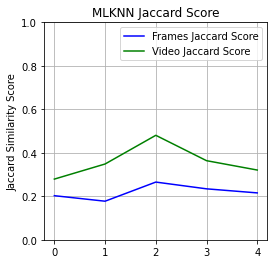

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.00, 1.0])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='best')
plt.show()

In [29]:
print("F-jac: ", np.mean(frames_mean_jac_test))
print("V-jac: ", np.mean(videos_mean_jac_test))
print("F-ham: ", np.mean(frames_mean_hm_test))
print("V-ham: ", np.mean(videos_mean_hm_test))


F-jac:  0.219188170142571
V-jac:  0.3586111111111111
F-ham:  0.2709892440539312
V-ham:  0.22380952380952382


In [28]:
videos_mean_jac_test

[0.2791666666666666,
 0.34861111111111115,
 0.48055555555555546,
 0.3638888888888889,
 0.3208333333333333]

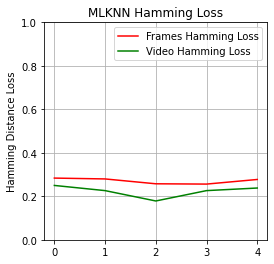

In [25]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, 1.0])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

In [ ]:
np.mean(frames_mean_hm_test)

In [ ]:
train_df.head()

Multilabel confusion matrix puts TN at (0,0) and TP at (1,1) position thanks @Kenneth Witham for pointing out.


`support`: The number of occurrences of each label in y_true.

In [27]:
print('------------------- Frame-level F1 -----------------')
print(metrics.classification_report(y_test, y_test_pred, target_names=label_cols))

print('------------------- Video-level F1 -----------------')
print(metrics.classification_report(np.array(ground_truth_video_labels,  dtype=int),  video_groups.values, target_names=label_cols))

------------------- Frame-level F1 -----------------
              precision    recall  f1-score   support

        none       0.01      0.02      0.01        93
     furious       0.79      0.15      0.25      1265
       anger       0.52      0.33      0.40      1447
     annoyed       0.40      0.43      0.41       781
    contempt       0.08      0.17      0.11       180
     disgust       0.00      0.00      0.00        81
      hatred       0.48      0.18      0.26       871

   micro avg       0.38      0.25      0.30      4718
   macro avg       0.33      0.18      0.21      4718
weighted avg       0.53      0.25      0.31      4718
 samples avg       0.32      0.26      0.27      4718

------------------- Video-level F1 -----------------
              precision    recall  f1-score   support

        none       0.00      0.00      0.00         2
     furious       0.00      0.00      0.00         9
       anger       0.62      0.80      0.70        10
     annoyed       0.43   

In [ ]:
print(type(y_test[0]))
print(type(y_test_pred[0].toarray()))
for i in range(len(y_test)):
    if metrics.hamming_loss(y_test[i].flatten(), Y_pred_chains[4][i].flatten()) > 0:
        print("Ground Truth: ", y_test[i], ", Prediction: ", Y_pred_chains[0][i])
        print("Video data: ", metadata_test.iloc[i])

In [ ]:
print(y_test[800:805])
print(metadata_test[800:805])

In [ ]:
print(len(y_test))
print(len(metadata_test))

In [ ]:
def clean(input: str):
    input = 'persian/' + input +".mp4"
    return input
X_df = pd.read_csv('../new_data/Persian/persian_dataset.csv', index_col=None)
X_df['filename'] = X_df['filename'].apply(clean)
X_df.to_csv('../new_data/Persian/persian_dataset.csv', index=False)